In [1]:
!pip install Cython
!pip install brian2
from brian2 import *
%matplotlib inline
import numpy as np
import scipy.sparse
import scipy.sparse.linalg

  Using cached https://files.pythonhosted.org/packages/c1/11/a67236633cf3cd884235dfc24422dc6bf35280888dbf724c21df7799d206/Brian2-2.2.1.tar.gz
  Stored in directory: /root/.cache/pip/wheels/2f/f8/b1/a51ad04c803031d9f580f3b390204a0ec4fb15881edd06203a
Successfully built brian2


In [0]:
#Initialize random weights for the internal reservoir conncetion 
def initWeight(n, density, rho):
    W = scipy.sparse.random(n, n, density, data_rvs=np.random.randn)
    eigw, _ = scipy.sparse.linalg.eigs(W, 1)
    W /= np.abs(eigw[0])
    return W.toarray() * rho

In [0]:
#Random noise input to the two networks for training
runtime_train = 3*second
random_input = TimedArray(np.random.randn(int(runtime_train/(10*defaultclock.dt))),
                      dt=defaultclock.dt*10)


In [0]:
#Sine wave input for testing
runtime_test = 1*second
sine_input = TimedArray(np.hstack([sin(2*0.003*np.array(range(int(0.5*runtime_test/defaultclock.dt)))),
                                   np.zeros(int(0.5*runtime_test/defaultclock.dt))]),dt=defaultclock.dt)


In [5]:
#Set parameters of the continuous ESN
netSizeM = 100
lambda_x = 1
tau = 150*defaultclock.dt
freq = 10*Hz
density = 0.2
w_input = 0.5*np.random.randn(netSizeM)

esr=0
while (esr < 0.95 or esr > 1.0):
  W = initWeight(netSizeM, density, 1)

  #Check the effective spectral radius
  W_tilde = (defaultclock.dt/tau)*W+(1-lambda_x*defaultclock.dt/tau)*np.identity(netSizeM)
  print "delta/c:", defaultclock.dt/tau 
  eigw, _ = np.linalg.eig(W_tilde)
  esr = np.abs(eigw[0])
  print "The effective spectral radius:", esr

  
  
#Define a group of leaky integrator units
stimulus = sine_input
equX = '''dx/dt=(-lambda_x*x+y)/tau : 1
          y = tanh(ysum+w_in*stimulus(t)) : 1
          s = stimulus(t) : 1
          ysum : 1
          w_in : 1 '''
units = NeuronGroup(netSizeM, model=equX)
#w_in is the input matrix 
units.w_in = w_input




#Connect the units by random weights
connectX = '''ysum_post = x_pre*w : 1 (summed)
              w : 1'''
SynX = Synapses(units, units, model=connectX)
SynX.connect()
SynX.w = W.flatten()


#Record variables of the network
unitM = StateMonitor(units, ('x', 'y', 's'), record=True)

delta/c: 0.00666666666667
The effective spectral radius: 0.9978590102698519


WARNING    /usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /root/.cython/brian_extensions/_cython_magic_c29a1be1872134f74ee2d3ac89d9d25e.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]


In [0]:
#Set parameters of the spiking network
netSizeN = netSizeM
lambda_v = lambda_x
lambda_s = lambda_v
res = 0
theta = 0.4


#Define a group of spiking neurons
equV = '''dv/dt=(-lambda_v*v+0.41+switchy*y+switchz*z+w_in*stimulus(t))/tau : 1
          z : 1
          y : 1
          dr/dt=(-lambda_s*r)/tau : 1
          w_in : 1 '''
resetV = '''v=res
            r+=1'''

neurons = NeuronGroup(netSizeN, model=equV, threshold='v > res+theta', reset=resetV, refractory=1*ms)
#w_in is the input matrix 
neurons.w_in = w_input


connectV = '''z_post = r_pre*w_syn : 1 (summed)
              w_syn : 1'''
#Connect the spiking neurons to themselves
SynV = Synapses(neurons, neurons, model=connectV)
SynV.connect()
SynV.w_syn = W.flatten()



neuronM = StateMonitor(neurons, ('v', 'y', 'r', 'z'), record=True)
spikeM = SpikeMonitor(neurons)

In [0]:
#Add connection from ESN to Spiking network for transfer
connectXV ='''y_post = x_pre*w : 1 (summed)
              w : 1'''
SynXV = Synapses(units, neurons, model=connectXV)
SynXV.connect()
SynXV.w = np.eye(netSizeM).flatten()


mixedRNN = Network([units, SynX, unitM, neurons, SynXV, neuronM, spikeM, SynV])

#Training


In [8]:
mixedRNN.store('t=0')
stimulus = random_input
switchy = 1 
switchz = 0
mixedRNN.run(runtime_train)


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.88s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.18s). [brian2.stateupdaters.base.method_choice]


In [0]:
r_mat = neuronM.r
y_mat = neuronM.y
s_mat = unitM.s
x_mat = unitM.x

In [0]:
#Train w_rt such that x=W_rt*r
alpha = 20
W_rt = np.linalg.inv(r_mat.dot(r_mat.T) + alpha * np.eye(netSizeN)).dot(r_mat).dot(x_mat.T).T

In [11]:
# Drive the transferred reservoir with sine wave, switch off teacher input
mixedRNN.restore('t=0')
SynV.w_syn = W_rt.flatten()
switchz=1
switchy=0
stimulus = sine_input
mixedRNN.run(runtime_test)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.94s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]


In [0]:
# Store the resulting PSC for plotting
r_transfer = neuronM.r

In [0]:
# Drive the random reservoir with sine wave, switch off teacher input
mixedRNN.restore('t=0')
SynV.w_syn = 0.4*W.flatten() # random weights are scaled, otherwise worse
switchz=1
switchy=0
stimulus = sine_input
mixedRNN.run(runtime_test)


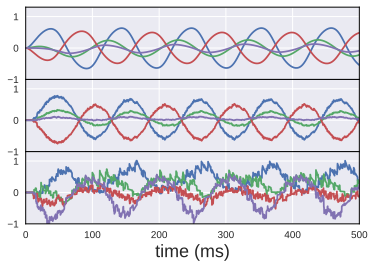

In [16]:
%config InlineBackend.figure_format = 'svg'

j = 20
num = 4
fig, axs = plt.subplots(3, 1, sharex=True)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.xlabel('time (ms)', fontsize=18)

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
for i in range(num):
  axs[0].plot(unitM.t/ms, unitM.x[j+i])
axs[0].set_xlim([0,500])
axs[0].set_ylim([-1,+1.3])

# subplot: state variables when using reservoir transfer weights
for i in range(num):
  axs[1].plot(neuronM.t/ms, W_rt.dot(r_transfer)[j+i])
axs[1].set_xlim([0,500])
axs[1].set_ylim([-1,+1.3])

# subplot: state variables when using random weights
for i in range(num):
  axs[2].plot(neuronM.t/ms, 0.4*W.dot(neuronM.r)[j+i])
axs[2].set_xlim([0,500])
axs[2].set_ylim([-1,1.3])

plt.savefig("responses.pdf", transparent=True)
